# SimPy ismertetése
Ebben a fejezetben a SimPy Python csomagot mutatjuk be. A modellek felépítését lépésről lépésre példákon keresztül ismertetjük. A SimPy egy folyamat alapú DES keretrendszer, ami a Python programnyelvre épül.

INSTALL - 
pip install simpy


In [1]:
#!pip install simpy


## 1. példa - Egy megmunkáló munkahely

Első lépésként megvizsgálunk egy egymunkagépes folyamatot, amely a bejövő megrendeléseket sorban egymás után dolgozza fel, mindegyiket ugyanazzal a feldolgozási idővel. A megmunkálás után ezek a munkadarabok azonnal kiszállításra is kerülnek közbelső tárolás nélkül.

<img src="figures/01_pelda.png" height="300" width="450">

Első lépésként meg kell hívni a SimPy programcsomagot az <i>import simpy</i> programsorral. A globális változókat, mint a műszak száma és ideje a programkód elején definiáljuk (<i>SHIFT_NUM, SHIFT_TIME</i>). Ezután a fő programrészben létrehozzuk a szimulációs SimPy környezetünket.


In [2]:
import matplotlib.pyplot as plt # for plots
import simpy
SHIFT_NUM = 1
SHIFT_TIME = 28800        # [s] Define the duration of shift
env = simpy.Environment() # Create SimPy environment

Definiáljuk a munkahelyet (<i>Machine</i> osztály), amelynek két paramétere lesz: az első a szimulációs környezet (env), a második pedig a feldolgozási ideje (<i>T<sub>f</sub></i>), ami a példában 60 másodperc.

A megmunkálóhelynek vannak saját paraméterei: <i>env</i>, ami a SimPy elemeit definiálja, a <i>working_time</i>, ami a munkahely munkával töltött összideje, <i>processing_time</i>, ami a feldolgozási ideje és végül a <i>parts_made</i> amiben tároljuk majd a gyártott késztermékek darabszámát. Ezeket az init függvényben definiáljuk.

A <i>Machine</i> viselkedését a working függvény írja le, ami ciklikusan hajtja végre az adott feladatokat (<i>while True</i>), amelyet a SimPy beépített függvénye kalkulál (<i>env.timeout</i>). Ez a gyakorlatban adott időegységig tartó várakozást jelent:

In [3]:
# Define Machine
class Machine(object):
    def __init__(self, env, processing_time):
        self.env = env
        self.working_time = 0
        self.processing_time = processing_time
        self.parts_made = 0
        self.process = env.process(self.working())

    def working(self):
        while True:
            start_time = env.now
            yield env.timeout(self.processing_time)
            self.parts_made += 1
            end_time = env.now
            self.working_time += end_time - start_time

A <i>start_time</i> és az <i>end_time</i> változókban rögzítjük egy adott munkadarab kezdeti és befejezési feldolgozási idejét a szimuláció során és a munkahelyre jel>lemző <i>T<sub>g</sub></i> gépidő ebből a két paraméterből származik. Az <i>env.timeout</i> függvénynek egy paramétere van, az adott munkahely feldolgozási ideje (<i>T<sub>f</sub></i>).

A fő programrészben a az <i>env.run</i> kódrész futtatja a szimulációt, amelynek az <i>until</i> bemenő paramétere a teljes szimulációs vizsgálati idő (<i>műszak ideje * műszak számmal</i>. A program végén a szimuláció eredményeinek kiíratása és a kihasználtság számítása található.

In [4]:
env = simpy.Environment() # Create SimPy environment
machine = Machine(env,60)               # Create machine
env.run(until=SHIFT_TIME*SHIFT_NUM+1)   # Run the simulation until SHIFT_TIME

# Results
utilization = machine.working_time/SHIFT_TIME*SHIFT_NUM*100
print("Produced parts: %d" % machine.parts_made)
print("Shift time: %ds" % SHIFT_TIME)
print("Processing time: %ds" % (machine.processing_time))
print("Loss time: %ds" % machine.working_time)
print("Waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machine.working_time))
print("Machine utilization: %d%%" % int(utilization))
print("Machine loss: %d%%" % (100-int(utilization)))

Produced parts: 480
Shift time: 28800s
Processing time: 60s
Loss time: 28800s
Waste time: 0s
Machine utilization: 100%
Machine loss: 0%


Az 1. példa programkódja egyben:

In [5]:
import simpy

SHIFT_NUM = 1
SHIFT_TIME = 28800  # [s] Define the duration of shift

# Define Machine
class Machine(object):
    def __init__(self, env, processing_time):
        self.env = env
        self.working_time = 0
        self.processing_time = processing_time
        self.parts_made = 0
        self.process = env.process(self.working())

    def working(self):
        while True:
            start_time = env.now
            yield env.timeout(self.processing_time)
            self.parts_made += 1
            end_time = env.now
            self.working_time += end_time - start_time


#%% MAIN

env = simpy.Environment()                 # Create SimPy environment
machine = Machine(env,60)                 # Create machine
env.run(until=SHIFT_TIME*SHIFT_NUM+1)     # Run the simulation until SHIFT_TIME

# Results
utilization = machine.working_time/SHIFT_TIME*SHIFT_NUM*100
print("Produced parts: %d" % machine.parts_made)
print("Shift time: %ds" % SHIFT_TIME)
print("Processing time: %ds" % (machine.processing_time))
print("Loss time: %ds" % machine.working_time)
print("Waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machine.working_time))
print("Machine utilization: %d%%" % int(utilization))
print("Machine loss: %d%%" % (100-int(utilization)))

Produced parts: 480
Shift time: 28800s
Processing time: 60s
Loss time: 28800s
Waste time: 0s
Machine utilization: 100%
Machine loss: 0%


## 2. példa - Egyszerű gyártósor

A második példában egy egyszerű gyártósort szimulálunk, amely összesen három gépből áll. Ezek egyféle terméket gyártanak ugyanazzal a feldolgozási idővel. A gépek között végtelen pufferek vannak (tehát nem blokkolják egymást).

<img src="figures/02_pelda.png" height="400" width="600">

A fő programrészben definiáljuk a terméket (<i>Product</i> osztály) és a munkahelyet (<i>Machine</i> osztály). A termékeknek két paramétere lesz, az első a szimulációs környezet (<i>env</i>) a második pedig az adott termék neve. A munkahelynek szintén ez a két paramétere lesz, de ezen kívül meg kell adnunk a feldolgozási idejét (<i>T<sub>f</sub></i>).

A termékek osztályban (<i>Product</i>) a label definiálja, hogy a munkadarabnak melyik munkahelyre kell éppen kerülnie, míg a <i>done</i> változó segítségével fogjuk megmondani, ha a munkadarab elkészült az utolsó munkahelyen is.

In [6]:
#Define Product
class Product(object):
    def __init__(self,env,name):
        self.env = env
        self.name = name
        self.label = 0
        self.done = 0

A megmunkálóhelynek az előző példában bemutatottakon túl vannak további paraméterei: a <i>start_time</i>, ami rögzíti a termékek feldolgozásának kezdeti idejét és a <i>res</i>, ami pedig hozzárendel egy-egy erőforrást a munkahelyekhez (<i>resource_machine</i>). Ezeket az init függvény definiálja:

In [7]:
# Define Machine
class Machine(object):
    def __init__(self, env, name, processing_time):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1) # All machine have resource with 1 capacity

A <i>resource_machine</i> függvény definiálja a szükséges erőforrásokat. Ennek a paramétere az adott gép sorszáma (<i>machine</i>). A SimPy <i>request</i> beépített függvényével foglalunk le egy-egy erőforrást minden egyes géphez, amely erőforrásokat a gép <i>res</i> változója definiál a SimPy beépített <i>Resource</i> függvényével, ahol a <i>capacity</i> határozza meg az erőforrások számát.

In [8]:
# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    machine.start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.res.release(request)

A working függvény definiálja a munkafolyamatot. Ezt elsőként minden termékkel meghívjuk a legelső munkagépre, ezzel elindítva minden egyes terméket a munkafolyamat legelején. A folyamatot a process meghívásával hajtjuk végre, amit az aktuális munkahely erőforrásával hívunk meg (<i>yield env.process(resource_machine(env,machine))</i>). Ezt csak abban az esetben tesszük meg, ha az adott termék <i>done</i> változója <i>0</i>, tehát még nem ért végig a teljes folyamaton.

Ezután a termékek <i>label</i> változójának segítségével folyamatosan, minden megmunkálás után változtatjuk a szükséges megmunkáló gép sorszámát (<i>products[idx].label += 1</i>). 


In [9]:
# Define working process
def working(machine,products,idx):
    if products[idx].done == 0: # if actual product already produced on the last machine, then it is done (done = 1)
        yield env.process(resource_machine(env,machine))
        machine.parts_made += 1
        end_time = env.now
        machine.working_time += end_time - machine.start_time

# Setup the next machine (if that was the last machine, then set the product's done field to 1, other case increase the product's label )
        if products[idx].label < NUM_MACHINES-1:
            products[idx].label += 1
        else:
            products[idx].done = 1
# Run the next machine in process flow, with actual product
        env.process(working(machines[products[idx].label],products,idx))

A fő programrészben a az <i>env.run</i> kódrész futtatja a szimulációt, amelynek az until bemenő paramétere a teljes szimulációs vizsgálati idő. A program végén a szimuláció eredményeinek kiíratása és a kihasználtság számítása található. Mivel a termékekből és gépekből is több lesz, ezért ezeket ciklussal hozzuk létre.

In [10]:
SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3    # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] Define assembly time of machine

env = simpy.Environment() # Create SimPy environment

# Create products
products = [Product(env, i)
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME)
            for i in range(NUM_MACHINES)]

# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    env.process(working(machines[0],products,i))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Loss time: %ds" % machines[i].working_time)
    print("Waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))


Shift time: 28800s

Statistic of Machine 0
Produced parts: 480
Loss time: 28800s
Waste time: 0s
Machine utilization: 100%
Machine loss: 0%

Statistic of Machine 1
Produced parts: 479
Loss time: 28740s
Waste time: 60s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 2
Produced parts: 478
Loss time: 28680s
Waste time: 120s
Machine utilization: 99%
Machine loss: 1%


A 2. példa programkódja egyben:

Shift time: 28800s

Statistic of Machine 0
Produced parts: 480
Loss time: 28800s
Waste time: 0s
Machine utilization: 100%
Machine loss: 0%

Statistic of Machine 1
Produced parts: 479
Loss time: 28740s
Waste time: 60s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 2
Produced parts: 478
Loss time: 28680s
Waste time: 120s
Machine utilization: 99%
Machine loss: 1%


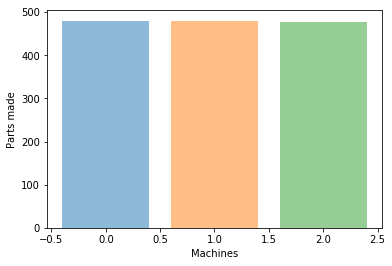

In [11]:
import simpy
import matplotlib.pyplot as plt

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3    # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] Define assembly time of machine

#Define Product
class Product(object):
    def __init__(self,env,name):
        self.env = env
        self.name = name
        self.label = 0
        self.done = 0

# Define Machine
class Machine(object):
    def __init__(self, env, name, processing_time):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1) # All machine have resource with 1 capacity

# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    machine.start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.res.release(request)

# Define working process
def working(machine,products,idx):
    if products[idx].done == 0: # if actual product already produced on the last machine, then it is done (done = 1)
        yield env.process(resource_machine(env,machine))
        machine.parts_made += 1
        end_time = env.now
        machine.working_time += end_time - machine.start_time

# Setup the next machine (if that was the last machine, then set the product's done field to 1, other case increase the product's label )
        if products[idx].label < NUM_MACHINES-1:
            products[idx].label += 1
        else:
            products[idx].done = 1
# Run the next machine in process flow, with actual product
        env.process(working(machines[products[idx].label],products,idx))

env = simpy.Environment() # Create SimPy environment

# Create products
products = [Product(env, i)
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME)
            for i in range(NUM_MACHINES)]

# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    env.process(working(machines[0],products,i))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Loss time: %ds" % machines[i].working_time)
    print("Waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')
    

## 3. példa - Gyártósor pufferekkel

Ebben a fejezetben egy az előző fejezethez hasonló gyártósort szimulálunk, de most minden megmunkáló egység elé elhelyezünk egy véges kapacitású puffert. A folyamat továbbra is összesen három gépből áll, amelyek egyféle terméket gyártanak ugyanazzal a feldolgozási idővel.

<img src="figures/02_pelda.png" height="400" width="600">

A fő programrészben definiáljuk a terméket, a munkahelyet és az erőforrásokat. Mivel a termékekből és gépekből is több lesz, ezért ezeket most is ciklussal hozzuk létre, mint az előző példában, hasonlóan definiáljuk a termékek osztály is.

A megmunkálóhelynek vannak saját paraméterei ezek nagy része egyenértékű az előző példával. Az új paraméter a <i>store</i> lesz, ami az adott munkahely pufferét definiálja (egy beépített SimPy függvény). További paramétere egy átmeneti változó az <i>ongoing</i>, amely az aktuális termék állapotát fogja meghatározni. Ezeket az init függvény definiálja:

In [12]:
# Define Machine
class Machine(object):
    def __init__(self, env, name, processing_time):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1)           # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.ongoing = 0                                    # Temporarly value for ongoing products
        self.product = 0
        
# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time

    start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.release(request)
    machine.parts_made += 1

A <i>working</i> függvény definiálja a munkafolyamatot. A folyamatot a process meghívásával hajtjuk végre, amit az aktuális munkahely erőforrásával hívunk meg (<i>yield env.process(resource_machine(env,machine))</i>). Ezt csak abban az esetben tesszük meg, ha még nem ért végig a teljes folyamaton az adott termék. A függvényben figyelembe vesszük, hogy a következő gép pufferében van-e hely az adott munkadarabnak, ha nem akkor várunk 1 másodpercet és ismét ellenőrizzük, egészen addig, míg fel nem szabadul egy hely, vagy le nem telik a szimuláció ideje. Ezután az adott terméket elhelyezzük a következő pufferben.
Ezután a termékek <i>label</i> változójának segítségével folyamatosan, minden megmunkálás után változtatjuk a szükséges megmunkáló gép sorszámát (<i>products[idx].label += 1</i>). 


In [13]:
# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            if machine.product.label < NUM_MACHINES-1:
                # Check the next machine's buffer
                if len(machines[machine.product.label+1].store.items) < machines[machine.product.label+1].store.capacity:
                    # if it's a new product, then increase the label and put the product to the next buffer
                    if machine.product.label < NUM_MACHINES-1 and machine.ongoing != 1:
                        machine.product.label += 1
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[machine.product.label].store.put(machine.product)
                    break
                else:
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                break

A véges kapacitású pufferek megjelenésével bevezetjük a blokkolt időtartam mutatót is a gépekre és ezt a <i>working</i> függvényben számoljuk. Ez az idő megadja, hogy az adott gép mennyi ideig volt blokkolva a következő puffer telítettsége miatt:
<i>machine.blocked_time += env.now - start_time</i>

A program végén a szimuláció eredményeinek kiíratása és a kihasználtság számítása található.


In [14]:
SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

env = simpy.Environment() # Create SimPy environment

# Create products
products = [Product(env, i)
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME*(i+1))
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Loss time: %ds" % machines[i].working_time)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))

Shift time: 28800s

Statistic of Machine 0
Produced parts: 165
Loss time: 9900s
Full waste time: 18900s
Wait time: 0s
Blocked time: 18782s
Machine utilization: 34%
Machine loss: 66%

Statistic of Machine 1
Produced parts: 162
Loss time: 19440s
Full waste time: 9360s
Wait time: 60s
Blocked time: 9241s
Machine utilization: 67%
Machine loss: 33%

Statistic of Machine 2
Produced parts: 159
Loss time: 28620s
Full waste time: 180s
Wait time: 180s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%


A 3. példa programkódja egyben:

Shift time: 28800s

Statistic of Machine 0
Produced parts: 165
Loss time: 9900s
Full waste time: 18900s
Wait time: 0s
Blocked time: 18782s
Machine utilization: 34%
Machine loss: 66%

Statistic of Machine 1
Produced parts: 162
Loss time: 19440s
Full waste time: 9360s
Wait time: 60s
Blocked time: 9241s
Machine utilization: 67%
Machine loss: 33%

Statistic of Machine 2
Produced parts: 159
Loss time: 28620s
Full waste time: 180s
Wait time: 180s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%


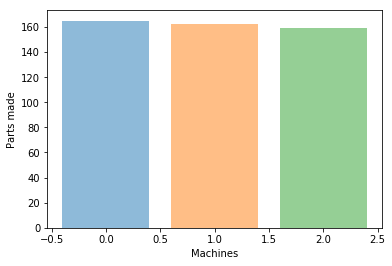

In [15]:
import matplotlib.pyplot as plt
import simpy

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

#Define Product
class Product(object):
    def __init__(self,env,name):
        self.env = env
        self.name = name
        self.label = 0

# Define Machine
class Machine(object):
    def __init__(self, env, name, processing_time):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1) # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.ongoing = 0                          # Temporarly value for ongoing products
        self.product = 0

# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time

    start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.release(request)
    machine.parts_made += 1

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            if machine.product.label < NUM_MACHINES-1:
                # Check the next machine's buffer
                if len(machines[machine.product.label+1].store.items) < machines[machine.product.label+1].store.capacity:
                    # if it's a new product, then increase the label and put the product to the next buffer
                    if machine.product.label < NUM_MACHINES-1 and machine.ongoing != 1:
                        machine.product.label += 1
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[machine.product.label].store.put(machine.product)
                    break
                else:
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                break


env = simpy.Environment() # Create SimPy environment

# Create products
products = [Product(env, i)
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME*(i+1))
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Loss time: %ds" % machines[i].working_time)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')



## 4. példa - Folyamat-elágazások kezelése

Ebben a fejezetben az elágazásokat vizsgáljuk, amikor a termék típusától függ a gyártási szekvencia és elágazások jelennek meg a gyártósoron.

<img src="figures/04_pelda.png" height="400" width="600">

A folyamat útvonalát MS Excel táblából töltjük be a könnyebb paraméterezhetőség kedvéért. Erre a Pandas csomagot hazsnáljuk:

In [16]:
import pandas as pd

# Read Excel table
rooting = pd.read_excel(R"files/rooting_table.xlsx")

A programban már nem az eddig megszokott <i>Product.label</i> változót használjuk a következő gép definiálására, hanem mindig a beolvasott rooting táblából keressük ki az éppen aktuális útvonalat az aktuális termék típusával és az aktuális munkahely nevének ismeretében:

<i>next_machine = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]</i>

In [17]:
class Product(object):
    def __init__(self,env,name,prod_type):
        self.env = env
        self.name = name
        self.done = 0
        self.type = prod_type # It'll define the rooting

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            next_machine = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]
            if next_machine != -1:
                # Check the next machine's buffer
                if len(machines[next_machine].store.items) < machines[next_machine].store.capacity:
                    if machine.ongoing != 1:
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[next_machine].store.put(machine.product)
                    break
                else:
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                machine.product.done = 1
                break

Ebben a példában megjelenik egy új kulcsmutató az összes gyártott mennyiség, aminek számításához a <i>Product</i> osztályban létrehozunk egy új változót a <i>Product.done</i>-t, aminek a segítségével a szimuláció végén megszámoljuk, hogy összesen mennyi kész termékük lett.

<i>for i in range(NUM_PRODUCTS):</i><br>
<span style="margin-left:2em"><i>full_produced += products[i].done</i>


In [18]:
import random

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

env = simpy.Environment() # Create SimPy environment

# Create products
products = [Product(env, i,int(random.uniform(0, 1)+0.5))
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME)
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME
full_produced = 0
for i in range(NUM_PRODUCTS):
    full_produced += products[i].done

# Print results
print("Shift time: %ds" % SHIFT_TIME)
print("Produced parts: %d" % full_produced)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Loss time: %ds" % machines[i].working_time)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))


Shift time: 28800s
Produced parts: 478

Statistic of Machine 0
Produced parts: 480
Loss time: 28800s
Full waste time: 0s
Wait time: 0s
Blocked time: 0s
Machine utilization: 100%
Machine loss: 0%

Statistic of Machine 1
Produced parts: 479
Loss time: 28740s
Full waste time: 60s
Wait time: 60s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 2
Produced parts: 244
Loss time: 14640s
Full waste time: 14160s
Wait time: 14160s
Blocked time: 0s
Machine utilization: 50%
Machine loss: 50%


A 4. példa programkódja egyben:

Shift time: 28800s
Produced parts: 478

Statistic of Machine 0
Produced parts: 480
Loss time: 28800s
Full waste time: 0s
Wait time: 0s
Blocked time: 0s
Machine utilization: 100%
Machine loss: 0%

Statistic of Machine 1
Produced parts: 479
Loss time: 28740s
Full waste time: 60s
Wait time: 60s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 2
Produced parts: 241
Loss time: 14460s
Full waste time: 14340s
Wait time: 14340s
Blocked time: 0s
Machine utilization: 50%
Machine loss: 50%


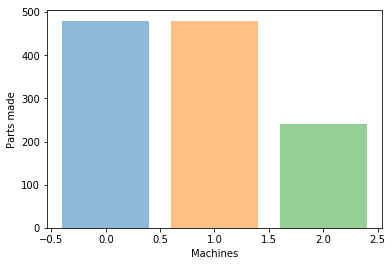

In [19]:
import matplotlib.pyplot as plt
import simpy
import pandas as pd
import random

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

# Read Excel table
rooting = pd.read_excel(R"files/rooting_table.xlsx")

#Define Product
class Product(object):
    def __init__(self,env,name,prod_type):
        self.env = env
        self.name = name
        self.done = 0
        self.type = prod_type # It'll define the rooting

# Define Machine
class Machine(object):
    def __init__(self, env, name, processing_time):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1) # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.ongoing = 0                          # Temporarly value for ongoing products
        self.product = 0

# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time

    start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.release(request)
    machine.parts_made += 1

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            next_machine = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]
            if next_machine != -1:
                # Check the next machine's buffer
                if len(machines[next_machine].store.items) < machines[next_machine].store.capacity:
                    if machine.ongoing != 1:
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[next_machine].store.put(machine.product)
                    break
                else:
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                machine.product.done = 1
                break


env = simpy.Environment() # Create SimPy environment

# Create products
products = [Product(env, i,int(random.uniform(0, 1)+0.5))
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME)
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME
full_produced = 0
for i in range(NUM_PRODUCTS):
    full_produced += products[i].done

# Print results
print("Shift time: %ds" % SHIFT_TIME)
print("Produced parts: %d" % full_produced)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Loss time: %ds" % machines[i].working_time)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')



## 5. példa - Sztochasztikus jelleg figyelembevétele

Ebben a fejezetben úgy módosítjuk a programunkat, hogy az figyelembe vegye az emberi tényezőt. Mivel sok esetben a gyártósoron nem robotok, hanem emberi operátorok dolgoznak, ezért a megmunkálási idők kis mértékben mindig változnak. Ennek a problémának a vizsgálatára az időket szórással látjuk el. Ehhez egy függvényt írunk, amely minden lépéshez számol egy normál eloszlású időt:

<i>def time_per_part():</i><br>
<span style="margin-left:2em"><i>return random.normalvariate(PT_MEAN, PT_SIGMA)</i>

Majd a függvény segítségével generáljuk mindig az aktuális megmunkálási időt a <i>resource_machine</i> függvényen belül:

<i>yield env.timeout(time_per_part())</i>

Így az eredményen már látszik, hogy ez a szórás hatással van a kihozatalra is. Az 5. példa programkódja egyben:

Shift time: 28800s

Statistic of Machine 0
Produced parts: 479
Working time: 28755s
Average process time: 60s
Full waste time: 44s
Wait time: 0s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 1
Produced parts: 477
Working time: 28644s
Average process time: 60s
Full waste time: 155s
Wait time: 143s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 2
Produced parts: 235
Working time: 14047s
Average process time: 59s
Full waste time: 14752s
Wait time: 14685s
Blocked time: 0s
Machine utilization: 48%
Machine loss: 52%


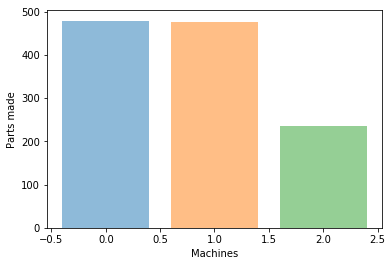

In [20]:
import matplotlib.pyplot as plt
import simpy
import pandas as pd
import random

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_PRODUCTS = 1000  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

RANDOM_SEED = 42
PT_MEAN = 60.0         # Avg. processing time in minutes
PT_SIGMA = 2.0         # Sigma of processing time

def time_per_part():
    """Return actual processing time for a concrete part."""
    return random.normalvariate(PT_MEAN, PT_SIGMA)

# Read Excel table
rooting = pd.read_excel(R"files/rooting_table.xlsx")

#Define Product
class Product(object):
    def __init__(self,env,name,prod_type):
        self.env = env
        self.name = name
        self.label = 0
        self.done = 0
        self.type = prod_type # It'll define the rooting
        self.quality_issue = 0

# Define Machine
class Machine(object):
    def __init__(self, env, name):
        self.env = env
        self.name = name
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1) # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.next_free = 1                        # It's 1 if the next workstation has enough storage
        self.ongoing = 0                          # Temporarly value for ongoing products
        self.product = 0
# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time
    start_time = env.now
    yield env.timeout(time_per_part())
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.release(request)
    machine.parts_made += 1

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            if rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)] != -1:
                # Check the next machine's buffer
                if len(machines[machine.product.label+1].store.items) < machines[machine.product.label+1].store.capacity:
                    machine.next_free = 1
                    # if it's a new product, then increase the label and put the product to the next buffer
                    if machine.product.label < NUM_MACHINES-1 and machine.ongoing != 1:
                        machine.product.label = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[machine.product.label].store.put(machine.product)
                    else:
                        machine.product.done = 1
                    break
                else:
                    machine.next_free = 0
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                machine.next_free = 1
                break


env = simpy.Environment() # Create SimPy environment
random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create products
products = [Product(env, i,int(random.uniform(0, 1)+0.5))
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i)
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    avg_proctime = machines[i].working_time/machines[i].parts_made
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Working time: %ds" % machines[i].working_time)
    print("Average process time: %ds" % avg_proctime)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')



## 6. példa - Selejtek kezelése

A selejtek kezelésére létrehozunk egy <i>to_quality</i> függvényt, melynek a segítségével véletlenszerűen tudunk hibás termékeket generálni:

In [21]:
RANDOM_SEED = 42
QUALITY_MEAN = 100

def to_quality():
    """Return actual processing time for a concrete part."""
    return random.expovariate(QUALITY_MEAN)

A selejteket a gépek generálják, ezért a <i>Machine</i> osztályban hozunk létre ezeknek a kezelésére két változót:

<i>self.quality = 0</i><br>
<i>self.quality_parts = 0</i>

A <i>to_quality</i> függvényt a <i>resource_machine</i> függvényben hívjuk meg, itt számolva az elkészített darabszámot:

<i>machine.quality += to_quality()</i>

A <i>working</i> függvényen belül figyeljük, hogy mikor érjük el a kritikus értéket, amelynél már szimulálunk egy hibás darabot. Hibás darab esetén azt újra megmunkáljuk az adott munkahelyen, tehát azonnal javítjuk is:

<i>if machine.quality > 1:</i><br>
<span style="margin-left:2em"><i>machine.quality = 0</i><br>
<span style="margin-left:2em"><i>machine.quality_parts += 1</i><br>
<span style="margin-left:2em"><i>yield env.process(resource_machine(env,machine))</i><br>
    
A 6. példa programkódja egyben:

Shift time: 28800s

Statistic of Machine 0
Produced parts: 480
Working time: 28800s
Average process time: 60s
Full waste time: 0s
Wait time: 0s
Blocked time: 0s
Machine utilization: 100%
Machine loss: 0%
Number of quality issues: 4

Statistic of Machine 1
Produced parts: 475
Working time: 28500s
Average process time: 60s
Full waste time: 300s
Wait time: 300s
Blocked time: 0s
Machine utilization: 98%
Machine loss: 2%
Number of quality issues: 4

Statistic of Machine 2
Produced parts: 256
Working time: 15360s
Average process time: 60s
Full waste time: 13440s
Wait time: 13380s
Blocked time: 0s
Machine utilization: 53%
Machine loss: 47%
Number of quality issues: 2


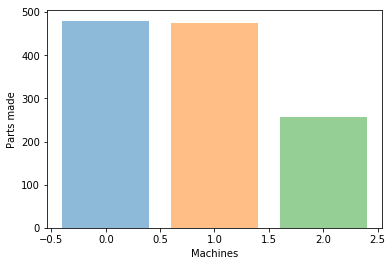

In [22]:
import matplotlib.pyplot as plt
import simpy
import pandas as pd
import random

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_PRODUCTS = 500  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

RANDOM_SEED = 42
QUALITY_MEAN = 100

def to_quality():
    """Return actual processing time for a concrete part."""
    return random.expovariate(QUALITY_MEAN)

# Read Excel table
rooting = pd.read_excel(R"files/rooting_table.xlsx")

#Define Product
class Product(object):
    def __init__(self,env,name,prod_type):
        self.env = env
        self.name = name
        self.label = 0
        self.done = 0
        self.type = prod_type # It'll define the rooting

# Define Machine
class Machine(object):
    def __init__(self, env, name, processing_time):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = simpy.Resource(env,capacity=1) # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.next_free = 1                        # It's 1 if the next workstation has enough storage
        self.ongoing = 0                          # Temporarly value for ongoing products
        self.product = 0
        self.quality = 0
        self.quality_parts = 0
# Define machine resource
def resource_machine(env, machine):
    request = machine.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time
    start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.quality += to_quality()
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.release(request)
    machine.parts_made += 1

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        if machine.quality > 1:
            machine.quality = 0
            machine.quality_parts += 1
            yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            if rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)] != -1:
                # Check the next machine's buffer
                if len(machines[machine.product.label+1].store.items) < machines[machine.product.label+1].store.capacity:
                    machine.next_free = 1
                    # if it's a new product, then increase the label and put the product to the next buffer
                    if machine.product.label < NUM_MACHINES-1 and machine.ongoing != 1:
                        machine.product.label = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[machine.product.label].store.put(machine.product)
                    else:
                        machine.product.done = 1
                    break
                else:
                    machine.next_free = 0
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                machine.next_free = 1
                break


env = simpy.Environment() # Create SimPy environment
#random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create products
products = [Product(env, i,int(random.uniform(0, 1)+0.5))
            for i in range(NUM_PRODUCTS)]
# Create machines
machines = [Machine(env, i, PROCESSING_TIME)
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    avg_proctime = machines[i].working_time/machines[i].parts_made
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Working time: %ds" % machines[i].working_time)
    print("Average process time: %ds" % avg_proctime)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    print("Number of quality issues: %d" % machines[i].quality_parts)
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')



## 7. példa - Közös erőforrások

Ebben a fejezetben megvizsgáljuk, hogy hogyan tudjuk kezelni, hogy kettő, vagy több géphez ugyanazt az erőforrást rendeljük, tehát közös erőforráson osztoznak. Ehhez létrehozunk egy új osztályt, a <i>Resource</i> osztályt:

In [23]:
class Resource(object):
    def __init__(self,env,name,capacity):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.res = simpy.Resource(env,capacity=1)

Majd legeneráljuk a rendelkezésünkre álló erőforrásokat és definiáljuk, hogy melyikeket melyik gépekhez rendeljük:

<i>resources = [Resource(env, i,1)</i><br>
<span style="margin-left:6em"><i>for i in range(NUM_RESOURCES)]</i><br>
<i>machine_resource = [0,1,1]</i><br>
<i>machines = [Machine(env, i, machine_resource[i], PROCESSING_TIME, resources)</i><br>
<span style="margin-left:6em"><i>for i in range(NUM_MACHINES)]</i>

Ennek kezelésére a resource_machine függvényt kell módosítanunk az alábbiak szerint:

<i>request = machine.res.res.request()</i>

Ezzel elértük, hogy az egyes erőforrások foglalhatók legyenek és a gépek blokkolva vannak, ha nincs a szükséges erőforrásból több kapacitás.

A 7. példa programkódja egyben:

Shift time: 28800s

Statistic of Machine 0
Produced parts: 6
Working time: 360s
Average process time: 60s
Full waste time: 28440s
Wait time: 0s
Blocked time: 1s
Machine utilization: 1%
Machine loss: 99%

Statistic of Machine 1
Produced parts: 3
Working time: 180s
Average process time: 60s
Full waste time: 28620s
Wait time: 60s
Blocked time: 0s
Machine utilization: 0%
Machine loss: 100%

Statistic of Machine 2
Produced parts: 2
Working time: 120s
Average process time: 60s
Full waste time: 28680s
Wait time: 0s
Blocked time: 0s
Machine utilization: 0%
Machine loss: 100%


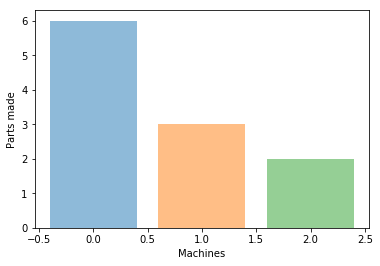

In [24]:
import matplotlib.pyplot as plt
import simpy
import pandas as pd
import random

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = 3     # [ ] number of machine
NUM_RESOURCES = 3
NUM_PRODUCTS = 500  # [ ] number of product
PROCESSING_TIME = 60 # [S] define assembly time of machine
BUFFER_SIZE = 2      # [ ] capacity of buffer

# Read Excel table
rooting = pd.read_excel(R"files/rooting_table.xlsx")

#Define Product
class Product(object):
    def __init__(self,env,name,prod_type):
        self.env = env
        self.name = name
        self.label = 0
        self.done = 0
        self.type = prod_type # It'll define the rooting

class Resource(object):
    def __init__(self,env,name,capacity):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.res = simpy.Resource(env,capacity=1)

# Define Machine
class Machine(object):
    def __init__(self, env, name, resource, processing_time, resources):
        self.env = env
        self.name = name
        self.processing_time = processing_time
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = resources[resource] # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.next_free = 1                        # It's 1 if the next workstation has enough storage
        self.ongoing = 0                          # Temporarly value for ongoing products
        self.product = 0

# Define machine resource
def resource_machine(env, machine):
    request = machine.res.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time
    start_time = env.now
    yield env.timeout(machine.processing_time)
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.res.release(request)
    machine.parts_made += 1

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            if rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)] != -1:
                # Check the next machine's buffer
                if len(machines[machine.product.label+1].store.items) < machines[machine.product.label+1].store.capacity:
                    machine.next_free = 1
                    # if it's a new product, then increase the label and put the product to the next buffer
                    if machine.product.label < NUM_MACHINES-1 and machine.ongoing != 1:
                        machine.product.label = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[machine.product.label].store.put(machine.product)
                    else:
                        machine.product.done = 1
                    break
                else:
                    machine.next_free = 0
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                machine.next_free = 1
                break


env = simpy.Environment() # Create SimPy environment
#random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create products
products = [Product(env, i,int(random.uniform(0, 1)+0.5))
            for i in range(NUM_PRODUCTS)]

resources = [Resource(env, i,1)
            for i in range(NUM_RESOURCES)]

machine_resource = [0,1,1]
# Create machines
machines = [Machine(env, i, machine_resource[i], PROCESSING_TIME, resources)
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    avg_proctime = machines[i].working_time/machines[i].parts_made
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Working time: %ds" % machines[i].working_time)
    print("Average process time: %ds" % avg_proctime)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')




## 8. példa - Interfészek

Ebben a fejezetben összekapcsoljuk a SimPy kódunkat egy MS Excel interfésszel. A példában szereplő táblázat három munkafüzetből áll:
1.	<i>rooting_table</i>
2.	<i>ProcessTime</i>
3.	<i>Resource</i>

A <i>rooting_table</i> használatát tárgyaltuk az előző fejezetekben. A <i>ProcessTime</i> és <i>Resource</i> munkafüzetek fogják definiálni minden megmunkáló helyre a megmunkálási időt és a szükséges erőforrásokat. Első lépésként beolvassuk ezeket a táblákat:

In [25]:
# Read Excel table
rooting = pd.read_excel(R"files/SimPy_interface_v2.xlsx", "rooting_table")
processing_times = pd.read_excel(R"files/SimPy_interface_v2.xlsx", "ProcessTime")
machine_resource = pd.read_excel(R"files/SimPy_interface_v2.xlsx", "Resource")


Majd legeneráljuk a gépeinket az adott erőforrás igénnyel:

<i>machines = [Machine(env, i, machine_resource["Resource"]["Machine " + str(i)])</i><br>
<span style="margin-left:6em"><i>for i in range(NUM_MACHINES)]</i>

A megmunkálási időt pedig módosítjuk a <i>resource_machine</i> függvényben:

<i>yield env.timeout(processing_times["Product type "+str(machine.product.type)]["Machine " + str(machine.name)])</i>

A 8. példa programkódja egyben, ahol az eredményeket egy excel fájlba mentjük az export könyvtárba:

Shift time: 28800s

Statistic of Machine 0
Produced parts: 480
Working time: 28800s
Average process time: 60s
Full waste time: 0s
Wait time: 0s
Blocked time: 0s
Machine utilization: 100%
Machine loss: 0%

Statistic of Machine 1
Produced parts: 479
Working time: 28740s
Average process time: 60s
Full waste time: 60s
Wait time: 60s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 2
Produced parts: 478
Working time: 28680s
Average process time: 60s
Full waste time: 120s
Wait time: 120s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 3
Produced parts: 477
Working time: 28620s
Average process time: 60s
Full waste time: 180s
Wait time: 180s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 4
Produced parts: 476
Working time: 28560s
Average process time: 60s
Full waste time: 240s
Wait time: 240s
Blocked time: 0s
Machine utilization: 99%
Machine loss: 1%

Statistic of Machine 5
Produced parts: 475
Wo

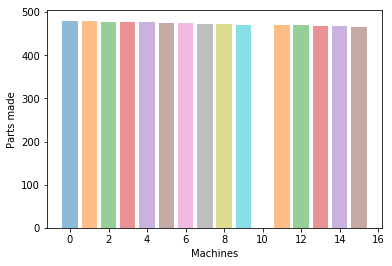

In [27]:
import matplotlib.pyplot as plt
import simpy
import pandas as pd
import random

# Read Excel table
rooting = pd.read_excel(R"files/SimPy_interface_v2.xlsx", "rooting_table")
processing_times = pd.read_excel(R"files/SimPy_interface_v2.xlsx", "ProcessTime")
machine_resource = pd.read_excel(R"files/SimPy_interface_v2.xlsx", "Resource")

SHIFT_NUM = 1        # [ ] number of shift
SHIFT_TIME = 28800   # [s] duration of shift
NUM_MACHINES = len(rooting)
NUM_RESOURCES = len(machine_resource)
NUM_PRODUCTS = 500  # [ ] number of product
BUFFER_SIZE = 2      # [ ] capacity of buffer

#Define Product
class Product(object):
    def __init__(self,env,name,prod_type):
        self.env = env
        self.name = name
        self.label = 0
        self.done = 0
        self.type = prod_type # It'll define the rooting

class Resource(object):
    def __init__(self,env,name,capacity):
        self.env = env
        self.name = name
        self.capacity = capacity
        self.res = simpy.Resource(env,capacity=1)

# Define Machine
class Machine(object):
    def __init__(self, env, name, resource):
        self.env = env
        self.name = name
        self.working_time = 0
        self.start_time = 0
        self.wait_time = 0
        self.blocked_time = 0
        self.parts_made = 0
        self.res = resources[resource] # All machine have a resource with 1 capacity
        self.store = simpy.Store(env, capacity=BUFFER_SIZE) # All machine have a buffer with a capacity
        self.next_free = 1                        # It's 1 if the next workstation has enough storage
        self.ongoing = 0                          # Temporarly value for ongoing products
        self.product = 0

# Define machine resource
def resource_machine(env, machine):
    request = machine.res.res.request()
    yield request
    start_time = env.now
    machine.product = yield machine.store.get()  # Get the next product from the machine's buffer (FIFO)
    machine.wait_time += env.now - start_time    # Calculate the waiting time
    start_time = env.now
    yield env.timeout(processing_times["Product type "+str(machine.product.type)]["Machine " + str(machine.name)])
    machine.working_time += env.now - start_time # Calculate the working time
    machine.res.res.release(request)
    machine.parts_made += 1

# Define working process
def working(machine):
    while True:
        yield env.process(resource_machine(env,machine)) # Call the machine's resource
        start_time = env.now
        machine.ongoing = 0
        while True:
            next_machine = rooting["Product type "+str(machine.product.type)]["Machine " + str(machine.name)]
            if next_machine != -1:
                # Check the next machine's buffer
                if len(machines[next_machine].store.items) < machines[next_machine].store.capacity:
                    # if it's a new product, then increase the label and put the product to the next buffer
                    if machine.ongoing != 1:
                        machine.ongoing = 1
                        machine.blocked_time += env.now - start_time
                        yield machines[next_machine].store.put(machine.product)
                    else:
                        machine.product.done = 1
                    break
                else:
                    yield env.timeout(1) # wait a sec, because of the next buffer's blocking
            else:
                break


env = simpy.Environment() # Create SimPy environment
#random.seed(RANDOM_SEED)  # This helps reproducing the results

# Create products
products = [Product(env, i,0)
            for i in range(NUM_PRODUCTS)]

resources = [Resource(env, i,1)
            for i in range(NUM_RESOURCES)]

# Create machines
machines = [Machine(env, i, machine_resource["Resource"]["Machine " + str(i)])
            for i in range(NUM_MACHINES)]


# Create inputs for the first machine
for i in range(NUM_PRODUCTS):
    machines[0].store.put(products[i])

for i in range(NUM_MACHINES):
    env.process(working(machines[i]))

env.run(until=SHIFT_TIME*SHIFT_NUM+1) # Run the simulation until SHIFT_TIME

# Print results
print("Shift time: %ds" % SHIFT_TIME)
for i in range(NUM_MACHINES):
    utilization = machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100
    if machines[i].parts_made != 0:
        avg_proctime = machines[i].working_time/machines[i].parts_made
    else:
        avg_proctime = 0
    print()
    print("Statistic of Machine %d" % machines[i].name)
    print("Produced parts: %d" % machines[i].parts_made)
    print("Working time: %ds" % machines[i].working_time)
    print("Average process time: %ds" % avg_proctime)
    print("Full waste time: %ds" % (SHIFT_TIME*SHIFT_NUM-machines[i].working_time))
    print("Wait time: %ds" % (machines[i].wait_time))
    print("Blocked time: %ds" % (machines[i].blocked_time))
    print("Machine utilization: %d%%" % int(utilization))
    print("Machine loss: %d%%" % (100-int(utilization)))
    plt.bar(machines[i].name, machines[i].parts_made, align='center', alpha=0.5)
    plt.xlabel('Machines')
    plt.ylabel('Parts made')

# KPIs to Excel
KPI_df = pd.DataFrame({ 'Machine name' : [(machines[i].name)for i in range(NUM_MACHINES)],
                        'Produced parts' : [(machines[i].parts_made)for i in range(NUM_MACHINES)],
                        'Working time' : [(machines[i].working_time)for i in range(NUM_MACHINES)],
                        'Full waste time' : [(SHIFT_TIME*SHIFT_NUM-machines[i].working_time)for i in range(NUM_MACHINES)],
                        'Wait time' : [(machines[i].wait_time)for i in range(NUM_MACHINES)],
                        'Blocked time' : [(machines[i].blocked_time)for i in range(NUM_MACHINES)],
                        'Machine utilization' : [(machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100)for i in range(NUM_MACHINES)],
                        'Machine loww' : [(100-machines[i].working_time/SHIFT_TIME*SHIFT_NUM*100)for i in range(NUM_MACHINES)]
                        })

KPI_df.to_excel(R"files/KPI.xlsx", sheet_name='KPI', index=False)

